In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import numpy as np
from scipy.integrate import quad
from scipy.special import hyp2f1
import math
from scipy.special import erf, erfcx
from scipy.integrate import trapezoid

# decay check

Text(0.5, 1.0, 'np.exp(-t_pts/0.05) +  (t_pts**n )/ ( t_pts**n + t0**n )')

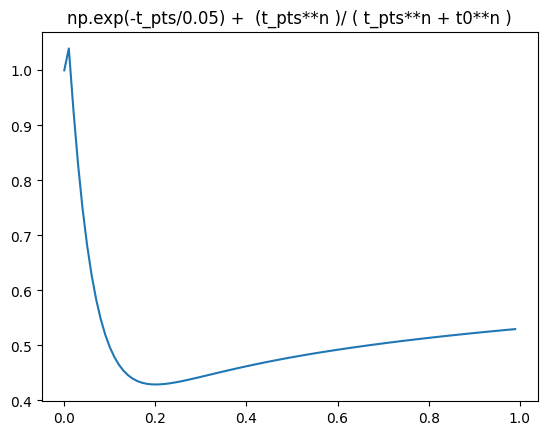

In [2]:
t_pts = np.arange(0, 1, 0.01)
n = 0.3
t0 = 0.2 / n

y = np.exp(-t_pts/0.05) +  (t_pts**n )/ ( t_pts**n + t0**n )

plt.plot(t_pts, y)
plt.title('np.exp(-t_pts/0.05) +  (t_pts**n )/ ( t_pts**n + t0**n )')

# check integration

In [3]:
import numpy as np
from scipy.integrate import quad
from scipy.special import hyp2f1
import math

def integrand(tau, t0, n):
    """
    The integrand: f(τ) = τ^n / (τ^n + t0^n)
    """
    return tau**n / (tau**n + t0**n)

def numeric_integral(t, t0, n):
    """
    Compute the integral numerically using scipy.integrate.quad.
    
    I(t) = ∫[0 to t] τ^n/(τ^n+t0^n) dτ
    """
    val, err = quad(integrand, 0, t, args=(t0, n))
    return val

def analytic_integral(t, t0, n):
    """
    Compute the analytic integral.
    
    It is known that
      I(t) = t * [1 - _2F_1(1/n, 1; 1+1/n; - (t/t0)^n)]
    where _2F_1 is the Gaussian hypergeometric function.
    """
    # Compute (t/t0)^n
    z = -(t/t0)**n
    # hyp2f1 takes parameters (a, b, c, z)
    hypergeom_val = hyp2f1(1/n, 1, 1 + 1/n, z)
    return t * (1 - hypergeom_val)

def test_integrals():
    """
    Test routine that compares the numerical and analytic integrals
    for several values of t and n.
    """
    # Parameters for testing:
    t0 = 1.0  # you may change t0 as needed
    t_values = [0.5, 1.0, 2.0]
    n_values = [1, 2, 3]
    
    print("Comparing numerical and analytic integration:")
    for n in n_values:
        for t in t_values:
            num_val = numeric_integral(t, t0, n)
            ana_val = analytic_integral(t, t0, n)
            diff = abs(num_val - ana_val)
            print(f"t = {t:4.2f}, t0 = {t0:4.2f}, n = {n:2d} --> "
                  f"Numeric = {num_val:10.6f}, Analytic = {ana_val:10.6f}, Diff = {diff:.2e}")


test_integrals()


Comparing numerical and analytic integration:
t = 0.50, t0 = 1.00, n =  1 --> Numeric =   0.094535, Analytic =   0.094535, Diff = 1.11e-16
t = 1.00, t0 = 1.00, n =  1 --> Numeric =   0.306853, Analytic =   0.306853, Diff = 2.22e-16
t = 2.00, t0 = 1.00, n =  1 --> Numeric =   0.901388, Analytic =   0.901388, Diff = 7.77e-16
t = 0.50, t0 = 1.00, n =  2 --> Numeric =   0.036352, Analytic =   0.036352, Diff = 2.43e-16
t = 1.00, t0 = 1.00, n =  2 --> Numeric =   0.214602, Analytic =   0.214602, Diff = 2.22e-16
t = 2.00, t0 = 1.00, n =  2 --> Numeric =   0.892851, Analytic =   0.892851, Diff = 0.00e+00
t = 0.50, t0 = 1.00, n =  3 --> Numeric =   0.014598, Analytic =   0.014598, Diff = 2.60e-17
t = 1.00, t0 = 1.00, n =  3 --> Numeric =   0.164351, Analytic =   0.164351, Diff = 5.55e-17
t = 2.00, t0 = 1.00, n =  3 --> Numeric =   0.909998, Analytic =   0.909998, Diff = 2.22e-16


# simulator - psiam + tied decay

In [4]:
def decay_amount_tied_fn(t, decay_params):
    gamma = decay_params['gamma']
    sig_slope = decay_params['sig_slope']
    sig_offset = 0.2 / sig_slope

    return np.exp(-t/gamma) + ( (t**n) / ((t**n) + (sig_offset**n)) )

def simulate_psiam_tied_decay(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, decay_params, dt):
    AI = 0; DV = Z_E; t = 0; dB = dt**0.5
    
    chi = 17.37; q_e = 1
    theta = theta_E * q_e
    common = (2 / T_0) * (10 ** (rate_lambda * ABL / 20))

    is_act = 0
    while True:
        if t > t_stim + t_E_aff:
            decay = decay_amount_tied_fn(t - t_stim - t_E_aff, decay_params)
            mu = common * (rate_lambda * ILD / chi) * decay
            sigma = np.sqrt(common * decay)

            DV += mu*dt + sigma*np.random.normal(0, dB)
        
        if t > t_A_aff:
            AI += V_A*dt + np.random.normal(0, dB)
        
        t += dt
        
        if DV >= theta:
            choice = +1; RT = t
            break
        elif DV <= -theta:
            choice = -1; RT = t
            break
        
        if AI >= theta_A:
            is_act = 1
            AI_hit_time = t
            while t <= (AI_hit_time + t_E_aff):#  u can process evidence till stim plays
                if t > t_stim + t_E_aff: # Evid accum wil begin only after stim starts and afferent delay
                    decay = decay_amount_tied_fn(t - t_stim - t_E_aff, decay_params)
                    mu = common * (rate_lambda * ILD / chi) * decay
                    sigma = np.sqrt(common * decay)

                    DV += mu*dt + sigma*np.random.normal(0, dB)
                    if DV >= theta:
                        DV = theta
                        break
                    elif DV <= -theta:
                        DV = -theta
                        break
                t += dt
            
            break
        
        
    if is_act == 1:
        RT = AI_hit_time
        if DV > 0:
            choice = 1
        elif DV < 0:
            choice = -1
        else: # if DV is 0 because stim has not yet been played, then choose right/left randomly
            randomly_choose_up = np.random.rand() >= 0.5
            if randomly_choose_up:
                choice = 1
            else:
                choice = -1       
    
    return choice, RT, is_act


# sim wrapper

In [5]:
def psiam_tied_decay_data_gen_wrapper(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_stim_arr, t_A_aff, t_E_aff, decay_params, dt):
    ABL = random.choice(ABL_arr)
    ILD = random.choice(ILD_arr)
    t_stim = random.choice(t_stim_arr)
    
    
    choice, rt, is_act = simulate_psiam_tied_decay(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, decay_params, dt)
    return {'choice': choice, 'rt': rt, 'is_act': is_act ,'ABL': ABL, 'ILD': ILD, 't_stim': t_stim}

# get ABL ILD and stim

In [6]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

df = df[  df['LED_trial'] == 0 ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)
# t_stim_arr = np.random.choice(df['intended_fix'], N_sim)


print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [7]:
ABL_arr = [40]
ILD_arr = [2]

# Sim params

In [8]:
np.random.choice(df['intended_fix'])

0.373543943102759

In [9]:
# V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_stim_arr, t_A_aff, t_E_aff, decay_params, dt
V_A = -2
theta_A = 2

rate_lambda = 0.2
T_0 = 1 * 1e-3
theta_E = 20
Z_E = 0
# t_A_aff = 30 * (1e-3)
# t_E_aff = 40 * (1e-3)
t_A_aff = 0
t_E_aff = 0

gamma = 0.05
sig_slope = 0.3
sig_offset = 0.2 / n

decay_params = { 'gamma': gamma, 'sig_slope': sig_slope }

N_sim = int(100e3)
# t_stim_arr = np.random.choice(df['intended_fix'], N_sim)
t_stim_arr = np.ones(N_sim)*0.21

dt = 1e-4
K_max = 10

In [10]:
sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_decay_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_stim_arr, t_A_aff, t_E_aff, decay_params, dt) for _ in tqdm(range(N_sim))) 

  0%|          | 0/100000 [00:00<?, ?it/s]

In [11]:
valid_sim_res = [res for res in sim_results if res['rt'] > res['t_stim']]
print(f'frac of valid rt = {len(valid_sim_res)}/{N_sim} = {len(valid_sim_res)/N_sim}')

frac of valid rt = 100000/100000 = 1.0


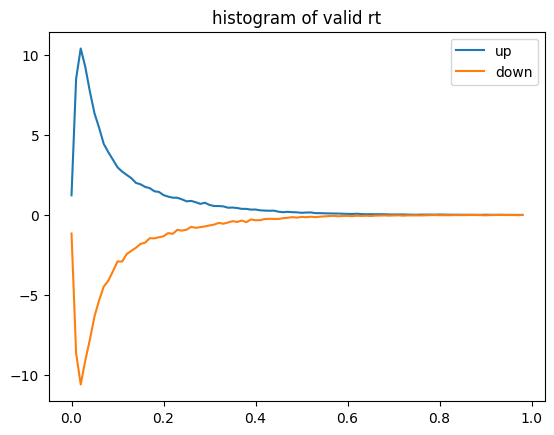

In [12]:
valid_rt_up = [res['rt'] - res['t_stim'] for res in valid_sim_res if res['choice'] == 1]
valid_rt_down = [res['rt'] - res['t_stim'] for res in valid_sim_res if res['choice'] == -1]

# hist
bins = np.arange(0, 1, 0.01)
valid_up_rt_hist, _ = np.histogram(valid_rt_up, bins=bins, density=True)
valid_down_rt_hist, _ = np.histogram(valid_rt_down, bins=bins, density=True)


plt.plot(bins[:-1], valid_up_rt_hist, label='up')
plt.plot(bins[:-1], -valid_down_rt_hist, label='down')
plt.legend()
plt.title('histogram of valid rt');

# likelihood theory and sim

# rho A 

In [13]:
def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


# P btn 1 and 2

In [14]:
def decay_integral(t, decay_params):
    """
    Compute the analytic integral.
    
    It is known that
      I(t) = t * [1 - _2F_1(1/n, 1; 1+1/n; - (t/t0)^n)]
    where _2F_1 is the Gaussian hypergeometric function.
    """
    gamma = decay_params['gamma']
    n = decay_params['sig_slope']
    t0 = 0.2 / sig_slope
    
    # exp part
    part_1 = gamma * ( 1 - np.exp(-t/gamma) )

    # sigmoid part
    z = -(t/t0)**n
    hypergeom_val = hyp2f1(1/n, 1, 1 + 1/n, z)
    part_2 =  t * (1 - hypergeom_val)

    return part_1 + part_2

def Phi(x):
    """
    Define the normal cumulative distribution function Φ(x) using erf
    """
    return 0.5 * (1 + erf(x / np.sqrt(2)))

def P_small_t_btn_x1_x2_vectorized(x1, x2, t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, decay_params, K_max):
    """
    Vectorized version of the P_small_t_btn_x1_x2 function.
    Computes the integration of P_small(x,t) between x1 and x2.
    """
    if t <= 0:
        return 0
    
    q_e = 1
    theta = theta_E * q_e

    chi = 17.37
    mu = theta_E * (rate_lambda * ILD / chi)
    z = (Z_E / theta) + 1.0

    # Compute t_theta and normalize t
    omega = (2 / (T_0 * (theta_E**2))) * (10 ** (rate_lambda * ABL / 20))  
    t_normalized = omega * decay_integral(t, decay_params)

    # Compute sqrt(t_normalized)
    sqrt_t = np.sqrt(t_normalized)
    
    # Handle potential division by zero
    sqrt_t = np.where(sqrt_t == 0, 1e-10, sqrt_t)

    # Create an array of n values from -K_max to K_max inclusive
    n = np.arange(-K_max, K_max + 1)

    # Compute exponentials for term1 and term2
    exp_term1 = np.exp(4 * mu * n)
    exp_term2 = np.exp(2 * mu * (2 * (1 - n) - z))

    # Compute arguments for Phi functions in term1
    phi1_upper = (x2 - (z + 4 * n + mu * t_normalized)) / sqrt_t
    phi1_lower = (x1 - (z + 4 * n + mu * t_normalized)) / sqrt_t

    # Compute Phi for term1
    Phi_term1 = Phi(phi1_upper) - Phi(phi1_lower)

    # Compute arguments for Phi functions in term2
    phi2_upper = (x2 - (-z + 4 * (1 - n) + mu * t_normalized)) / sqrt_t
    phi2_lower = (x1 - (-z + 4 * (1 - n) + mu * t_normalized)) / sqrt_t

    # Compute Phi for term2
    Phi_term2 = Phi(phi2_upper) - Phi(phi2_lower)

    # Compute term1 and term2
    term1 = exp_term1 * Phi_term1
    term2 = exp_term2 * Phi_term2

    # Compute the result by summing over all n
    result = np.sum(term1 - term2)

    return result


# CDF E minus

In [15]:
def M(x):
    """Mills ratio."""
    x = np.clip(x, -20, 20)
    return np.sqrt(np.pi / 2) * erfcx(x / np.sqrt(2))


def phi(x):
    """Standard Gaussian function."""
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

def CDF_E_minus_small_t_NORM_fn_vectorized(t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max):
    """
    Vectorized version of the CDF of hitting the lower bound in normalized time.
    Utilizes custom phi and M functions.

    Parameters:
    - t (float or np.ndarray): Time variable(s).
    - ABL, ILD, rate_lambda, T_0, theta_E, Z_E (float): Model parameters.
    - bound (int): Bound flag (0 or 1).
    - K_max (int): Maximum k value for summation.

    Returns:
    - np.ndarray: CDF values corresponding to each t.
    """
    # Convert t to a NumPy array for vectorized operations
    t = np.asarray(t, dtype=np.float64)
    
    # Initialize the CDF result array with zeros
    CDF = np.zeros_like(t, dtype=np.float64)
    
    # Create a boolean mask where t > 0
    mask = t > 0
    
    if not np.any(mask):
        # If all t <= 0, return the initialized CDF (all zeros)
        return CDF
    
    # Extract only the t values where t > 0 for computation
    t_valid = t[mask]
    
    q_e = 1
    theta = theta_E * q_e

    chi = 17.37
    v = theta_E * (rate_lambda * ILD / chi)
    w = (Z_E + theta) / (2 * theta)
    a = 2
    if bound == 1:
        v = -v
        w = 1 - w

    # Compute t_theta and normalize t
    omega = (2 / (T_0 * (theta_E**2))) * (10 ** (rate_lambda * ABL / 20))  
    t_normalized = omega * decay_integral(t_valid, decay_params)

    # Compute the exponential component of the CDF
    result = np.exp(-v * a * w - ((v ** 2) * t_normalized) / 2)

    # Create the k array
    k = np.arange(K_max + 1)
    
    # Determine even indices
    is_even = (k % 2 == 0).astype(float)
    
    # Compute r_k using broadcasting
    r_k = k * a + a * np.where(is_even, w, 1 - w)  # Shape: (K_max + 1,)
    
    # Compute sqrt(t_normalized) and handle zero to avoid division by zero
    sqrt_t = np.sqrt(t_normalized)
    sqrt_t = np.where(sqrt_t == 0, 1e-10, sqrt_t)  # Shape: (num_valid_t,)
    
    # Reshape r_k and sqrt_t for broadcasting
    # r_k: (K_max +1, 1)
    # sqrt_t: (1, num_valid_t)
    # This allows broadcasting to compute r_k / sqrt_t for all combinations
    r_k = r_k[:, np.newaxis]  # Shape: (K_max +1, 1)
    sqrt_t = sqrt_t[np.newaxis, :]  # Shape: (1, num_valid_t)
    
    phi_args = r_k / sqrt_t  # Shape: (K_max +1, num_valid_t)
    
    M_args_positive = (r_k - v * t_normalized) / sqrt_t  # Shape: (K_max +1, num_valid_t)
    M_args_negative = (r_k + v * t_normalized) / sqrt_t  # Shape: (K_max +1, num_valid_t)
    
    assert np.all(np.isfinite(phi_args)), "phi_args contains invalid values"
    assert np.all(np.isfinite(M_args_positive)), "M_args_positive contains invalid values"
    assert np.all(np.isfinite(M_args_negative)), "M_args_negative contains invalid values"

       
    phi_vals = phi(phi_args)  # Assuming phi is vectorized: Shape: (K_max +1, num_valid_t)
    M_vals = M(M_args_positive) + M(M_args_negative)  # Assuming M is vectorized

    ### M values are infinitely large for inputs less than -10 ###
    invalid_M_vals = ~np.isfinite(M_vals)
    if np.any(invalid_M_vals):
        print("Invalid M_vals detected:")
        invalid_indices = np.argwhere(invalid_M_vals)
        num_to_print = min(2, len(invalid_indices))
        for i in range(num_to_print):
            k_idx, t_idx = invalid_indices[i]
            print(f"M_vals[{k_idx}, {t_idx}] = {M_vals[k_idx, t_idx]}")
            print(f"M_args_positive[{k_idx}, {t_idx}] = {M_args_positive[k_idx, t_idx]}")
            print(f"M_args_negative[{k_idx}, {t_idx}] = {M_args_negative[k_idx, t_idx]}")
            print("---")

    assert np.all(np.isfinite(M_vals)), "M_vals contains invalid values"
    
    sign = (-1) ** k  # Shape: (K_max +1,)
    sign = sign[:, np.newaxis]  # Shape: (K_max +1, 1)
    
    summation = np.sum(sign * phi_vals * M_vals, axis=0)  # Shape: (num_valid_t,)
    
    CDF_valid = result * summation  # Shape: (num_valid_t,)
    
    CDF[mask] = CDF_valid
    
    return CDF


# rho E minus

In [16]:
def rho_E_minus_small_t_NORM_fn(t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max):
    """
    in normalized time, PDF of hitting the lower bound
    """
    if t <= 0:
        return 0
    
    q_e = 1
    theta = theta_E*q_e 

    chi = 17.37
    v = theta_E * (rate_lambda * ILD / chi)
    w = (Z_E + theta)/(2*theta)
    a = 2
    if bound == 1:
        v = -v
        w = 1 - w

    # t_theta = T_0 * (theta_E**2) * (10**(-rate_lambda*ABL/20)) * (1/(2*np.cosh(rate_lambda*ILD/chi)))
    # t /= t_theta
    # Compute t_theta and normalize t
    omega = (2 / (T_0 * (theta_E**2))) * (10 ** (rate_lambda * ABL / 20))  
    t = omega * decay_integral(t, decay_params)
    dtau_by_dt = omega * decay_amount_tied_fn(t, decay_params)

    non_sum_term = (1/a**2)*(a**3/np.sqrt(2*np.pi*t**3))*np.exp(-v*a*w - (v**2 * t)/2)
    K_max = int(K_max/2)
    k_vals = np.linspace(-K_max, K_max, 2*K_max + 1)
    sum_w_term = w + 2*k_vals
    sum_exp_term = np.exp(-(a**2 * (w + 2*k_vals)**2)/(2*t))
    sum_result = np.sum(sum_w_term*sum_exp_term)

    
    density =  non_sum_term * sum_result
    if density <= 0:
        density = 1e-16

    return density * dtau_by_dt


# cum A 

In [17]:
def cum_A_t_fn(t, V_A, theta_A):
    """
    For AI, calculate cummulative distrn of a time t given V_A, theta_A
    """
    if t <= 0:
        return 0

    term1 = Phi(V_A * ((t) - (theta_A/V_A)) / np.sqrt(t))
    term2 = np.exp(2 * V_A * theta_A) * Phi(-V_A * ((t) + (theta_A / V_A)) / np.sqrt(t))
    return term1 + term2

In [18]:
def up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, decay_params ,K_max):
    """
    PDF of up RTs array
    """
    bound = 1

    P_A = [rho_A_t_fn(t-t_A_aff, V_A, theta_A) for t in t_pts]
    P_EA_btn_1_2 = [P_small_t_btn_x1_x2_vectorized(1, 2, t - t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, decay_params, K_max) for t in t_pts]
    P_E_plus_cum = np.zeros(len(t_pts))
    for i,t in enumerate(t_pts):
        t1 = t - t_stim - t_E_aff
        t2 = t - t_stim
        P_E_plus_cum[i] = CDF_E_minus_small_t_NORM_fn_vectorized(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max) \
                    - CDF_E_minus_small_t_NORM_fn_vectorized(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max)


    P_E_plus = [rho_E_minus_small_t_NORM_fn(t-t_E_aff-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max) for t in t_pts]
    C_A = [cum_A_t_fn(t-t_A_aff, V_A, theta_A) for t in t_pts]

    P_A = np.array(P_A); P_EA_btn_1_2 = np.array(P_EA_btn_1_2); P_E_plus = np.array(P_E_plus); C_A = np.array(C_A)
    P_correct_unnorm = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))
    return P_correct_unnorm, P_A, C_A

In [19]:
t_pts = np.arange(0, 1, 0.01)
ABL = ABL_arr[0]
ILD = ILD_arr[0]
t_stim = t_stim_arr[0] 
theory_up_rt, P_A, C_A = up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, decay_params, 10)

area under theory = 0.6349855951394274
area under sim = 0.7113335257655592


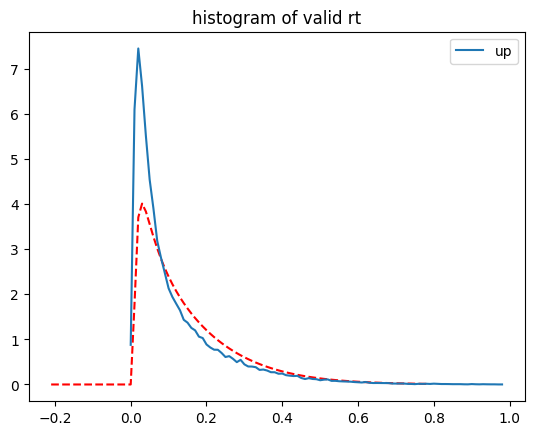

In [20]:
plt.plot(t_pts- t_stim, theory_up_rt, color='r', ls='--')

bins = np.arange(0, 1, 0.01)
valid_up_rt_hist, _ = np.histogram(valid_rt_up, bins=bins, density=True)

N_up = len(valid_rt_up)
plt.plot(bins[:-1], valid_up_rt_hist*(N_up/N_sim), label='up')
plt.legend()
plt.title('histogram of valid rt');

print(f'area under theory = {trapezoid(theory_up_rt, t_pts)}')
print(f'area under sim = {trapezoid(valid_up_rt_hist, bins[:-1]) * (N_up/N_sim)}')



(-0.1, 0.2)

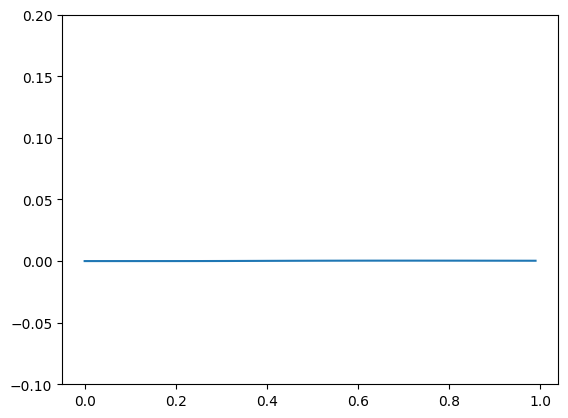

In [21]:
plt.plot(t_pts, P_A)
plt.ylim(-0.1, 0.2)

(0.9, 1.1)

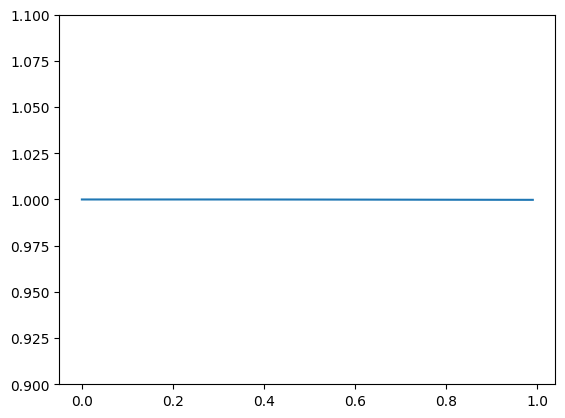

In [22]:
plt.plot(t_pts, 1 - C_A)
plt.ylim(0.9,1.1)
